# Single Beam
This notebook will run the ISR simulator with a set of data created from a function that makes test data. The results along with error bars are plotted below.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import os,inspect
import scipy as sp
import pdb
from RadarDataSim.utilFunctions import readconfigfile,makeconfigfile
from RadarDataSim.IonoContainer import IonoContainer,MakeTestIonoclass
from RadarDataSim.runsim import main as runsim 
from RadarDataSim.analysisplots import analysisdump
import seaborn as sns

## Set up Config Files
Setting up a configuration files and the directory needed to run the simulation. The simualtor assumes that for each simulation there is a dedicated directory to save out data along the different processing stages. The simulator also assumes that there is a configuration file which is created in the following cell using a default one that comes with the code base. The only parameter the user should have to set is the number of pulses.

In [16]:
# set the number of pulses
npulses = 150
curloc = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
testpath = os.path.join(os.path.split(curloc)[0],'Testdata','Notebookexample1')
if not os.path.isdir(testpath):
    os.mkdir(testpath)

defaultpath = os.path.join(os.path.split(curloc)[0],'Test')
defcon = os.path.join(defaultpath,'statsbase.ini')
(sensdict,simparams) = readconfigfile(defcon)

tint = simparams['IPP']*npulses
ratio1 = tint/simparams['Tint']
simparams['Tint']=ratio1 * simparams['Tint']
simparams['Fitinter'] = ratio1 * simparams['Fitinter']
simparams['TimeLim'] = tint

simparams['startfile']='startfile.h5'
makeconfigfile(os.path.join(testpath,'stats.ini'),simparams['Beamlist'],sensdict['Name'],simparams)

## Make Input Data
This section will create a set of input parmeters that can be used to create ISR Data. It uses a function MakeTestIonoclass which will create a set of plasma parameters that varies with altitude depending on the the function inputs. This data is put into an ionocontainer class, which is used as a container class to move data between the radarData class, fitter class and plotting modules. It has a standard format so any radar data or plasma parameters for the simulator can be saved in this.

A start file is also made which will be used as the starting parameter values used in the fitter. The starting points for the fitter use a nearest neighbor in space to what is found in the start file.

In [17]:

finalpath = os.path.join(testpath,'Origparams')
if not os.path.isdir(finalpath):
    os.mkdir(finalpath)
z = (50.+sp.arange(120)*5.)
nz = len(z)
coords = sp.column_stack((sp.zeros((nz,2)),z))
Icont1=MakeTestIonoclass(testv=False,testtemp=True,N_0=1e11,z_0=250.0,H_0=50.0,coords=coords,times =sp.array([[0,1e6]]))

Icontstart = MakeTestIonoclass(testv=False,testtemp=False,N_0=1e11,z_0=250.0,H_0=50.0,coords=coords,times =sp.array([[0,1e6]]))

finalfile = os.path.join(finalpath,'0 stats.h5')
Icont1.saveh5(finalfile)
Icontstart.saveh5(os.path.join(testpath,'startfile.h5'))

## Run Simulation
The simulation is run through the submodule runsim and its main function, renamed in this as runsim. This function will call all of the neccesary classes and functions to run the simulator. It will save out the data based off of an internal set of file names.

This function must get a configuration file and a list of functionalities it is to perform. Below the runsim function will create spectra form the plasma parameters, create radar data and then fit it.

In [18]:
functlist = ['spectrums','radardata','fitting']

config = os.path.join(testpath,'stats.ini')

runsim(functlist,testpath,config,True)

Processing file 0 stats.h5 starting at 2016-07-14 14:01:55.393009

	 Time:0 of 1 Location:0 of 120, now making spectrum.
	 Time:0 of 1 Location:1 of 120, now making spectrum.
	 Time:0 of 1 Location:2 of 120, now making spectrum.
	 Time:0 of 1 Location:3 of 120, now making spectrum.
	 Time:0 of 1 Location:4 of 120, now making spectrum.
	 Time:0 of 1 Location:5 of 120, now making spectrum.
	 Time:0 of 1 Location:6 of 120, now making spectrum.
	 Time:0 of 1 Location:7 of 120, now making spectrum.
	 Time:0 of 1 Location:8 of 120, now making spectrum.
	 Time:0 of 1 Location:9 of 120, now making spectrum.
	 Time:0 of 1 Location:10 of 120, now making spectrum.
	 Time:0 of 1 Location:11 of 120, now making spectrum.
	 Time:0 of 1 Location:12 of 120, now making spectrum.
	 Time:0 of 1 Location:13 of 120, now making spectrum.
	 Time:0 of 1 Location:14 of 120, now making spectrum.
	 Time:0 of 1 Location:15 of 120, now making spectrum.
	 Time:0 of 1 Location:16 of 120, now making spectrum.
	 Time:0

False

## Plotting
The data is plotted along with error bars derived from the fitter.

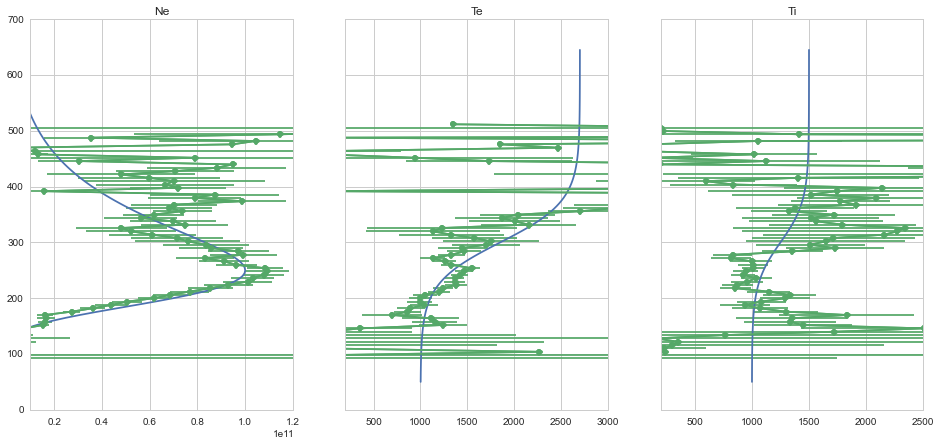

In [28]:
sns.set_style("whitegrid")
sns.set_context("notebook")
fig1,axmat =plt.subplots(1,3,figsize = (16,7),sharey=True)
axvec = axmat.flatten()
fittedfile = os.path.join(testpath,'Fitted','fitteddata.h5')
fitiono = IonoContainer.readh5(fittedfile)
paramlist = ['Ne','Te','Ti']
indlist =[sp.argwhere(ip==fitiono.Param_Names)[0][0] for ip in paramlist]
n_indlist =[sp.argwhere(('n'+ip)==fitiono.Param_Names)[0][0] for ip in paramlist]

altin =Icont1.Cart_Coords[:,2]
altfit = fitiono.Cart_Coords[:,2]

in_ind=[[1,0],[1,1],[0,1]]
pbounds = [[1e10,1.2e11],[200.,3000.],[200.,2500.],[-100.,100.]]
for i,iax in enumerate(axvec):
    iinind = in_ind[i]
    ifitind = indlist[i]
    n_ifitind = n_indlist[i]
    #plot input
    indata = Icont1.Param_List[:,0,iinind[0],iinind[1]]
    iax.plot(indata,altin)
    #plot fitted data
    fitdata = fitiono.Param_List[:,0,ifitind]
    fit_error = fitiono.Param_List[:,0,n_ifitind]
    ploth=iax.plot(fitdata,altfit)[0]
    iax.set_xlim(pbounds[i])
    iax.errorbar(fitdata,altfit,xerr=fit_error,fmt='-o',color=ploth.get_color())
    iax.set_title(paramlist[i])